<div style="text-align:left;"><img src="images/header_pic.png" style="display:inline-block;"/></div>

# Semester Project

## Introduction

The rise in accidents involving cyclists in Zurich over the past ten years has led to increased calls for the development of safer and more robust bicycle paths. The data showed a steady increase in the number of accidents involving cyclists, with the number of accidents more than doubling in the past decade. Despite several efforts to expand bike lanes, such as the implementation of separated bike lanes, progress in this area has been slow. The lack of action on this issue has raised concerns among citizens and cycling advocacy groups who are calling for more to be done to improve the safety of cyclists on the road.

The goal of this research is to examine patterns in traffic accidents involving cyclists in Zurich. This study will analyze known factors such as time of day, day of the week, month, accident severity and vulnerable road sections. The data used in this analysis was collected over a period of 10 years and was obtained through an API from the city of Zurich's open data portal in JSON format. The data was then stored in MongoDB, a non-relational document database that supports JSON-like storage, and analyzed using the pymongo library to create various aggregations. The data flow is illustrated in the accompanying figure, which shows the process of data collection, storage, and analysis. This analysis provides an in-depth understanding of the patterns and trends in accidents involving cyclists in Zurich and can inform policy decisions to improve the safety of cyclists on the road.


<img src="images/dataflow.png" style="height:350px;">
<br><br><br>
The structure of the JSON-file used is shown in the next graphic.

<img src="images/uml_no_sql.png" style="height:800px;">

In the next chapter, the necessary libraries are imported, the API is defined, and the corresponding local database is created in MongoDB.

##  Requirements & Configuration

In [1]:
! pip3 list | grep "pymongo dnspython pandas"

You should consider upgrading via the '/Users/matthias/Documents/nosql_lab/venv/bin/python -m pip install --upgrade pip' command.


### Import of Libraries

In [2]:
import pymongo
from pprint import pprint
import pandas as pd
import requests
import json
import datetime
import matplotlib.pyplot as plt
import descartes
import geopandas as gpd
from shapely.geometry import Point, Polygon

%matplotlib inline

### Pandas Configuration

In [3]:
pd.set_option('display.precision', 2)
pd.set_option('display.max_rows', 30)
pd.set_option('display.max_colwidth', 50)

### Setting API and Database details

In [4]:
API_URL = 'https://data.stadt-zuerich.ch/dataset/sid_dav_strassenverkehrsunfallorte/download/RoadTrafficAccidentLocations.json'
CNX_STR = "localhost:27017"
DB_NAME = "zh_accidents"
COLL_NAME = "accidents"

### Connection to MongoDB

In [5]:
client = pymongo.MongoClient(CNX_STR)
# set database 'icnb' -> db
db = client[DB_NAME]
# set collection "COLL_NAME"
accidents = db[COLL_NAME]
# list collections
db.list_collection_names()

['accidents_flat', 'accidents']

## ETL

In this chapter, the data is retrieved via the API and saved as a json file. Subsequently, the number of documents is determined and the JSON structure of the respective documents is displayed. If the data has the correct format, the created database is filled and the data is displayed as pandas dataframe.

### Remove all existing documents -> Reset collection

In [6]:
accidents.drop()
accidents.count_documents({})

0

###  Fetch data

#### Fetch accidents in JSON from API_URL

In [7]:
r_accidents = requests.get(API_URL, verify=False)
# print first 1000 characters of response text
r_accidents.text[:1000]

/Users/matthias/Documents/nosql_lab/venv/lib/python3.9/site-packages/urllib3/connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'data.stadt-zuerich.ch'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


'{\r\n\t"type" : "FeatureCollection",\r\n\t"name" : "RoadTrafficAccidentLocations_GEOJSON",\r\n\t"features" : [\r\n\t\t{\r\n\t\t\t"type" : "Feature",\r\n\t\t\t"geometry" : {\r\n\t\t\t\t"type" : "Point",\r\n\t\t\t\t"coordinates" : [ 8.55841025, 47.3521677, 0 ]\r\n\t\t\t},\r\n\t\t\t"properties" : {\r\n\t\t\t\t"AccidentUID" : "A2D2677533867004E0430A865E337004",\r\n\t\t\t\t"AccidentType" : "at0",\r\n\t\t\t\t"AccidentType_de" : "Schleuder- oder Selbstunfall",\r\n\t\t\t\t"AccidentType_fr" : "dérapage ou perte de maîtrise",\r\n\t\t\t\t"AccidentType_it" : "Incidente di sbandamento o per colpa propria",\r\n\t\t\t\t"AccidentType_en" : "Accident with skidding or self-accident",\r\n\t\t\t\t"AccidentSeverityCategory" : "as4",\r\n\t\t\t\t"AccidentSeverityCategory_de" : "Unfall mit Sachschaden",\r\n\t\t\t\t"AccidentSeverityCategory_fr" : "accident avec dommages matériels",\r\n\t\t\t\t"AccidentSeverityCategory_it" : "Incidente con danni materiali",\r\n\t\t\t\t"AccidentSeverityCategory_en" : "Accident 

#### Convert text to JSON -> data_accidents

In [8]:
data_accidents = json.loads(r_accidents.text)

#### Save JSON data to file to inspect

In [9]:
filename = f'accidents_data_{datetime.datetime.now().strftime("%Y%m%d")}.json'
print(filename)
with open(filename, 'w', encoding='utf-8') as f:
    json.dump(data_accidents, f)

accidents_data_20221221.json


#### Show number of documents

In [10]:
len(data_accidents['features'])

53446

#### Show json structure for one element

In [11]:
pprint(data_accidents['features'][42])

{'geometry': {'coordinates': [8.54906891, 47.40064283, 0], 'type': 'Point'},
 'properties': {'AccidentHour': '10',
                'AccidentHour_text': '10h-11h',
                'AccidentInvolvingBicycle': 'false',
                'AccidentInvolvingMotorcycle': 'false',
                'AccidentInvolvingPedestrian': 'false',
                'AccidentLocation_CHLV95_E': '2683823',
                'AccidentLocation_CHLV95_N': '1250573',
                'AccidentMonth': '1',
                'AccidentMonth_de': 'Januar',
                'AccidentMonth_en': 'January',
                'AccidentMonth_fr': 'janvier',
                'AccidentMonth_it': 'Gennaio',
                'AccidentSeverityCategory': 'as4',
                'AccidentSeverityCategory_de': 'Unfall mit Sachschaden',
                'AccidentSeverityCategory_en': 'Accident with property damage',
                'AccidentSeverityCategory_fr': 'accident avec dommages '
                                               'matériels'

### Insert into MongoDB

#### Insert the list of accidents in "features" into MongoDB collection "accidents"

In [12]:
accidents.insert_many(
   data_accidents['features']
);

#### Count number of documents inserted

In [13]:
accidents.count_documents({})

53446

#### Show document structure

In [14]:
c = accidents.aggregate([
      {"$limit": 1},
])

for doc in c:
     pprint(f"{doc}"[:500])

("{'_id': ObjectId('63a30a09f023c0daa78a5e6d'), 'type': 'Feature', 'geometry': "
 "{'type': 'Point', 'coordinates': [8.55841025, 47.3521677, 0]}, 'properties': "
 "{'AccidentUID': 'A2D2677533867004E0430A865E337004', 'AccidentType': 'at0', "
 "'AccidentType_de': 'Schleuder- oder Selbstunfall', 'AccidentType_fr': "
 "'dérapage ou perte de maîtrise', 'AccidentType_it': 'Incidente di "
 "sbandamento o per colpa propria', 'AccidentType_en': 'Accident with skidding "
 "or self-accident', 'AccidentSeverityCategory': 'as4', 'Acc")


### Transform

The data is still nested in the current state. By means of aggregation, the relevant fields are to be selected and the nesting removed. Afterwards the data will be searched for missing values.

#### Insert five entries into a pandas dataframe

In [15]:
# show df structure
c = accidents.aggregate([
      {"$limit": 5},
])

pd.DataFrame(c)

,_id,type,geometry,properties
0,63a30a09f023c0daa78a5e6d,Feature,"{'type': 'Point', 'coordinates': [8.55841025, ...",{'AccidentUID': 'A2D2677533867004E0430A865E337...
1,63a30a09f023c0daa78a5e6e,Feature,"{'type': 'Point', 'coordinates': [8.52932024, ...",{'AccidentUID': '9FD6441F802C20A6E0430A865E332...
2,63a30a09f023c0daa78a5e6f,Feature,"{'type': 'Point', 'coordinates': [8.5348767, 4...",{'AccidentUID': '9FDA0DC4856A6094E0430A865E336...
3,63a30a09f023c0daa78a5e70,Feature,"{'type': 'Point', 'coordinates': [8.51368203, ...",{'AccidentUID': 'A3B66E42396E6000E0430A865E336...
4,63a30a09f023c0daa78a5e71,Feature,"{'type': 'Point', 'coordinates': [8.53128819, ...",{'AccidentUID': '9FDA0DBE8CCE9096E0430A865E339...


#### Create new collection selecting relevant fields and flatten the nested structure 

In [16]:
db.accidents.aggregate([
    {"$addFields": {"hour":                   "$properties.AccidentHour",
                    "involvingBicycle":        "$properties.AccidentInvolvingBicycle",
                    "involvingMotorcycle":     "$properties.AccidentInvolvingMotorcycle",
                    "involvingPedestrian":     "$properties.AccidentInvolvingPedestrian",
                    "month_number":            "$properties.AccidentMonth",
                    "month":                   "$properties.AccidentMonth_en",
                    "accidentCategory":        "$properties.AccidentSeverityCategory_en",
                    "severityCategory":        "$properties.AccidentSeverityCategory",
                    "accidentType":            "$properties.AccidentType_en",
                    "weekDay":                 "$properties.AccidentWeekDay_en",
                    "year":                    "$properties.AccidentYear",
                    "roadType":                "$properties.RoadType_en",
                    "municipalityCode":        "$properties.MunicipalityCode",
                    "loc_geo_coord_long":   {"$arrayElemAt": ["$geometry.coordinates", 0]},
                    "loc_geo_coord_latt":   {"$arrayElemAt": ["$geometry.coordinates", 1]},
                        }},
    {"$project": {"properties": 0,"geometry": 0}},   # remove nested location
    {"$out": "accidents_flat"}
    ])

db.accidents_flat.count_documents({})

53446

#### Check structure of documents in collection "accidents_flat"

In [17]:
for d in db.accidents_flat.find().limit(2):
    pprint(d)

{'_id': ObjectId('63a30a09f023c0daa78a5e6d'),
 'accidentCategory': 'Accident with property damage',
 'accidentType': 'Accident with skidding or self-accident',
 'hour': '00',
 'involvingBicycle': 'false',
 'involvingMotorcycle': 'false',
 'involvingPedestrian': 'false',
 'loc_geo_coord_latt': 47.3521677,
 'loc_geo_coord_long': 8.55841025,
 'month': 'January',
 'month_number': '1',
 'municipalityCode': '0261',
 'roadType': 'Minor road',
 'severityCategory': 'as4',
 'type': 'Feature',
 'weekDay': 'Saturday',
 'year': '2011'}
{'_id': ObjectId('63a30a09f023c0daa78a5e6e'),
 'accidentCategory': 'Accident with light injuries',
 'accidentType': 'Accident with skidding or self-accident',
 'hour': '01',
 'involvingBicycle': 'true',
 'involvingMotorcycle': 'false',
 'involvingPedestrian': 'false',
 'loc_geo_coord_latt': 47.36851152,
 'loc_geo_coord_long': 8.52932024,
 'month': 'January',
 'month_number': '1',
 'municipalityCode': '0261',
 'roadType': 'Minor road',
 'severityCategory': 'as3',
 'ty

#### Analyse the relation between accidents severity code and accidents severity description

In [18]:
pipline = [
    { "$unwind": "$properties.AccidentSeverityCategory" },
    { "$group": { "_id": {"category":"$properties.AccidentSeverityCategory", 
                          "category_desc":"$properties.AccidentSeverityCategory_en"}, 
                 "count": { "$sum": 1 } } },
    { "$sort": { "count": -1, "_id": -1 } }
]

cursor = client['zh_accidents'].accidents.aggregate(pipline)
accidents_agg = pd.DataFrame(cursor)
print(accidents_agg.to_string())

                                                                     _id  count
0  {'category': 'as4', 'category_desc': 'Accident with property damage'}  40092
1   {'category': 'as3', 'category_desc': 'Accident with light injuries'}  11010
2  {'category': 'as2', 'category_desc': 'Accident with severe injuries'}   2267
3       {'category': 'as1', 'category_desc': 'Accident with fatalities'}     77


#### Check for NULL and missing values

In [19]:
for check in db.accidents_flat.find_one().keys():
    
    # find document where field value is None
    for d in db.accidents_flat.find({check: {"$exists": False}}):
        pprint(d)
        
    # find document where field value is type 10 == None
    for d in db.accidents_flat.find({check: {"$type": 10}}):
        pprint(d)

    # find document where filed name is missing    
    for d in db.accidents_flat.find({check: None}).limit(2):
        pprint(d)   
    print("Field: ", check, "-> Check Done!" )
print("Check Done!")

Field:  _id -> Check Done!
Field:  type -> Check Done!
Field:  hour -> Check Done!
Field:  involvingBicycle -> Check Done!
Field:  involvingMotorcycle -> Check Done!
Field:  involvingPedestrian -> Check Done!
Field:  month_number -> Check Done!
Field:  month -> Check Done!
Field:  accidentCategory -> Check Done!
Field:  severityCategory -> Check Done!
Field:  accidentType -> Check Done!
Field:  weekDay -> Check Done!
Field:  year -> Check Done!
Field:  roadType -> Check Done!
Field:  municipalityCode -> Check Done!
Field:  loc_geo_coord_long -> Check Done!
Field:  loc_geo_coord_latt -> Check Done!
Check Done!


## Data analysis

After the data has been brought into the desired state and been checked for missing values, the analysis can now begin. The analysis should be limited to accidents in which cyclists were involved and only accidents in which there were deaths or injuries should be taken into account.
In the next subsection, the severity of the accidents, the type of accidents and the different types of roads are displayed.

###  Inspect types of accidents and road types

#### Accident by severity

In [20]:
db.accidents.distinct("properties.AccidentSeverityCategory_en")

['Accident with fatalities',
 'Accident with light injuries',
 'Accident with property damage',
 'Accident with severe injuries']

#### Accident by type of accident

In [21]:
db.accidents.distinct("properties.AccidentType_en")

['Accident involving animal(s)',
 'Accident involving pedestrian(s)',
 'Accident when crossing the lane(s)',
 'Accident when overtaking or changing lanes',
 'Accident when parking',
 'Accident when turning left or right',
 'Accident when turning-into main road',
 'Accident with head-on collision',
 'Accident with rear-end collision',
 'Accident with skidding or self-accident',
 'Other']

#### Type of roads

In [22]:
db.accidents.distinct("properties.RoadType_en")

['Expressway',
 'Minor road',
 'Motorway',
 'Motorway side installation',
 'Other',
 'Principal road']

#### Aggregate by type and severity of accident

In [23]:
pipline = [
    { "$unwind": "$properties.AccidentSeverityCategory" },
    { "$group": { "_id": {"category":"$properties.AccidentSeverityCategory", 
                          "category_desc":"$properties.AccidentSeverityCategory_en"}, 
                 "count": { "$sum": 1 } } },
    { "$sort": { "count": -1, "_id": -1 } }
]

cursor = client['zh_accidents'].accidents.aggregate(pipline)

accidents_agg = pd.DataFrame(cursor)
print(accidents_agg.to_string())

                                                                     _id  count
0  {'category': 'as4', 'category_desc': 'Accident with property damage'}  40092
1   {'category': 'as3', 'category_desc': 'Accident with light injuries'}  11010
2  {'category': 'as2', 'category_desc': 'Accident with severe injuries'}   2267
3       {'category': 'as1', 'category_desc': 'Accident with fatalities'}     77


For each accident, the severity is described and the responsible code is indicated:<br>
Category "as1" stands for Accident with fatalities<br>
Category "as2" stands for Accident with severe injuries<br>
Category "as3" stands for Accident with light injuries<br>
Category "as4" stands for Accident with property damage

### Total accidents by year

In this subchapter the accidents with involved cyclists per year are shown. The first graph shows all accidents with bicyclists, the second graph shows all accidents with bicyclists where there were deaths or injured.

#### Total number accidents involving bicycles by year 

In [229]:
pipeline = [
        { "$project": {"_id": 1, "involvingBicycle": 1, "year": 1,}},
        { "$match": {"involvingBicycle": {"$eq": "true"}}},
        { "$group": { "_id": "$year", "count": {"$sum": 1}}},
        { "$sort": { "_id": 1} }
        ]

cursor = client['zh_accidents'].accidents_flat.aggregate(pipeline)

accidents_agg = pd.DataFrame(cursor)
accidents_agg

,_id,count
0,2011,335
1,2012,356
2,2013,362
3,2014,424
4,2015,536
5,2016,584
6,2017,614
7,2018,692
8,2019,695
9,2020,761


Next we plot the dataframe as bar plot:

Text(0, 0.5, '# of accidents')

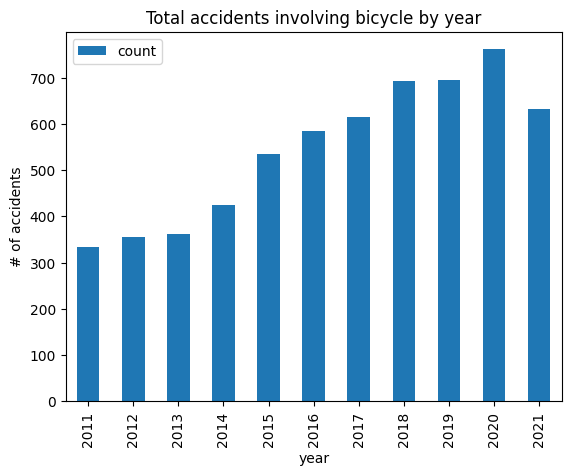

In [161]:
ax = accidents_agg.plot.bar(x='_id', title='Total accidents involving bicycle by year')
ax.set_xlabel("year")
ax.set_ylabel("# of accidents")

#### Total number of accidents with injuries or fatalities involving bicycles by year

In [117]:
pipeline = [
        { "$project": {"_id": 1, "involvingBicycle": 1, "year": 1, "severityCategory": 1}},
        { "$match": {"involvingBicycle": {"$eq": "true"}, "severityCategory": {"$ne": "as4"}}},
        { "$group": { "_id": "$year", "count": {"$sum": 1}}},
        { "$sort": { "_id": 1} }
        ]

cursor = client['zh_accidents'].accidents_flat.aggregate(pipeline)

accidents_agg = pd.DataFrame(cursor)
accidents_agg

,_id,count
0,2011,280
1,2012,314
2,2013,310
3,2014,363
4,2015,442
5,2016,472
6,2017,475
7,2018,558
8,2019,568
9,2020,617


Next we plot the dataframe as bar plot:

Text(0, 0.5, '# of accidents')

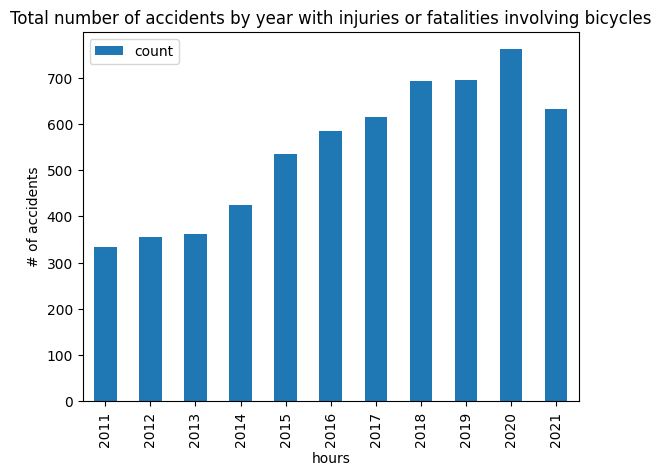

In [129]:
ax = accidents_agg.plot.bar(x='_id', y='count', 
                            title='Total number of accidents with injuries or fatalities involving bicycles by year')
ax.set_xlabel("hours")
ax.set_ylabel("# of accidents")

The graphs clearly show that the number of accidents with fatalities and injuries makes up the largest part of the accidents. It can also be seen that the number of accidents has more than doubled in the last ten years. Only in 2021 is there a significant decrease, which may be related to the limited mobility during the corona pandemic.

### Accidents by hour

In this subchapter, we want to find out whether accidents occur particularly often at certain times of the day. In the first graph again only accidents with fatalities or injuries are shown. In the second graph, only accidents with fatalities or injuries are shown, and the accidents are shown separately according to severity.

#### Total number of accidents with injuries or fatalities involving bicycles by hour 

In [130]:
pipeline = [
        { "$project": {"_id": 1, "involvingBicycle": 1, "hour": 1, "severityCategory": 1}},
        { "$match": {"involvingBicycle": {"$eq": "true"}, "severityCategory": {"$ne": "as4"}}},
        { "$group": { "_id": "$hour", "count": {"$sum": 1}}},
        { "$sort": { "_id": 1} }     
        ]

cursor = client['zh_accidents'].accidents_flat.aggregate(pipeline)

accidents_agg = pd.DataFrame(cursor)
accidents_agg

,_id,count
0,00,103
1,01,85
2,02,56
3,03,46
4,04,40
5,05,34
6,06,106
7,07,284
8,08,399
9,09,239


Next we plot the dataframe as bar plot:

Text(0, 0.5, '# of accidents')

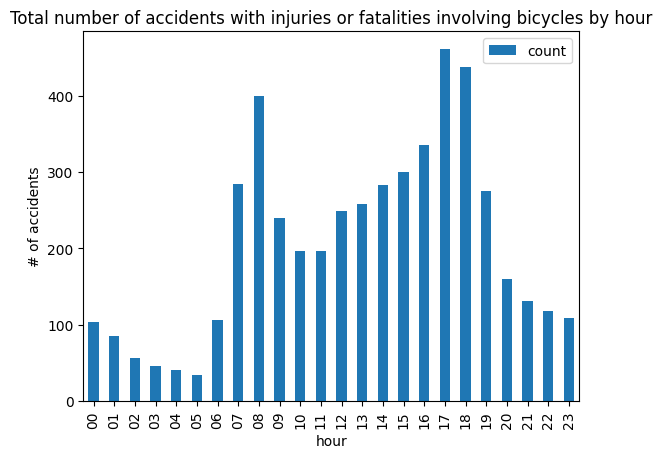

In [131]:
ax = accidents_agg.plot.bar(x='_id', y='count', 
                            title='Total number of accidents with injuries or fatalities involving bicycles by hour')
ax.set_xlabel("hour")
ax.set_ylabel("# of accidents")

#### Average number of accidents by hour with injuries or fatalities involving bicycles

In [281]:
pipeline = [
        { "$project": {"_id": 1, "involvingBicycle": 1, "year": 1, "hour": 1, "roadType": 1}},
        { "$match": {"involvingBicycle": {"$eq": "true"}}},
        { "$addFields": {"hour_int": {"$toInt": "$hour"}}},
        { "$addFields": {"involvingBicycle_bool": {"$toBool": "$involvingBicycle"}}},
        { "$addFields": {"involvingBicycle_int": {"$toInt": "$involvingBicycle_bool"}}},
        { "$group": {"_id": { "hour": "$hour", "road_type": "$roadType"}, 
                     "total": { "$sum": "$involvingBicycle_int"}}},
        { "$group": {"_id": { "hour": "$_id.hour"}, "avg": { "$avg": "$total"}}},
        { "$sort": { "_id": 1} }
        ]

cursor = client['zh_accidents'].accidents_flat.aggregate(pipeline)

accidents_agg = pd.DataFrame(cursor)
accidents_agg

,_id,avg
0,{'hour': '00'},37.33
1,{'hour': '01'},33.33
2,{'hour': '02'},19.33
3,{'hour': '03'},27.50
4,{'hour': '04'},16.00
5,{'hour': '05'},13.33
6,{'hour': '06'},41.00
7,{'hour': '07'},109.33
8,{'hour': '08'},163.33
9,{'hour': '09'},101.00


Next we plot the dataframe as bar plot:

Text(0, 0.5, '# of accidents')

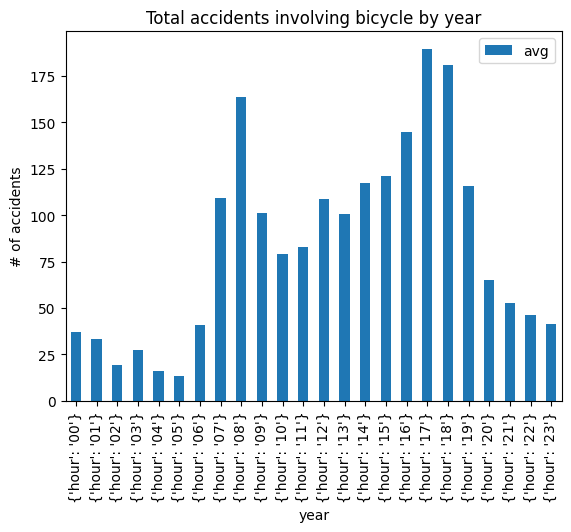

In [282]:
ax = accidents_agg.plot.bar(x='_id', title='Total accidents involving bicycle by year')
ax.set_xlabel("year")
ax.set_ylabel("# of accidents")

#### Total number of accidents with injuries or fatalities involving bicycles divided by severity by hour

In [133]:
pipeline = [
        { "$project": {"_id": 1, "involvingBicycle": 1, "hour": 1, "severityCategory": 1}},
        { "$match": {"involvingBicycle": {"$eq": "true"}, "severityCategory": {"$ne": "as4"}}},
    
        { "$addFields": {
          "deadly_acc": { "$cond": {"if": {"$eq": ["$severityCategory", "as1"]}, "then":1, "else":0}},
          "severe_inj": { "$cond": {"if": {"$eq": ["$severityCategory", "as2"]}, "then":1, "else":0}},
          "light_inj": { "$cond": {"if": {"$eq": ["$severityCategory", "as3"]}, "then":1, "else":0}}}},
    
        { "$group": {"_id": "$hour", 
                     "deadly": { "$sum": "$deadly_acc"},
                     "severe": { "$sum": "$severe_inj"},
                     "light": { "$sum": "$light_inj"}}},
    
        { "$sort": { "_id": 1} }
        ]

cursor = client['zh_accidents'].accidents_flat.aggregate(pipeline)

accidents_agg = pd.DataFrame(cursor)
accidents_agg

,_id,deadly,severe,light
0,00,0,26,77
1,01,0,28,57
2,02,0,19,37
3,03,0,11,35
4,04,0,12,28
5,05,0,11,23
6,06,1,30,75
7,07,0,48,236
8,08,1,78,320
9,09,2,41,196


Next we plot the dataframe as line plot:

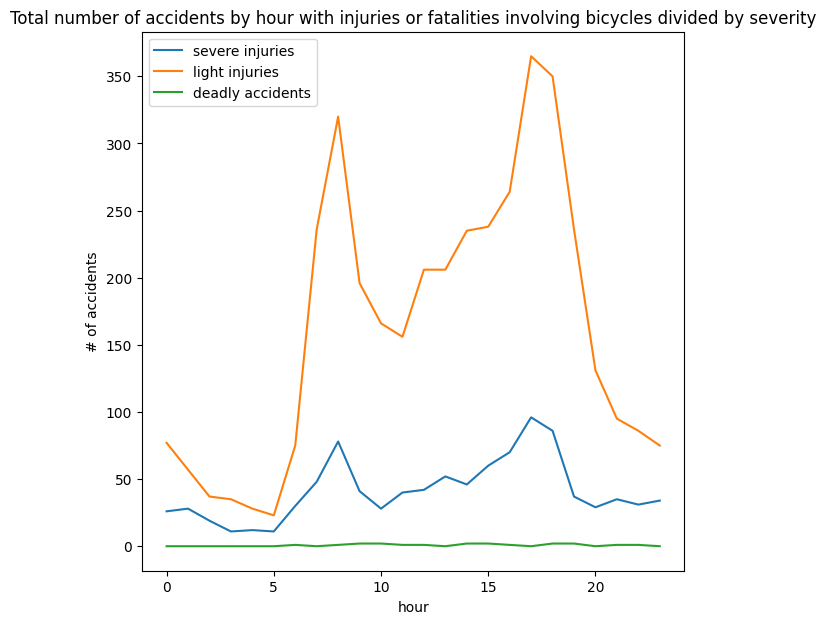

In [134]:
fig,ax = plt.subplots(figsize = (7, 7))
ax = accidents_agg['severe'].plot(
    title='Total number of accidents with injuries or fatalities involving bicycles divided by severity by hour')
accidents_agg['light'].plot(ax=ax)
accidents_agg['deadly'].plot(ax=ax)
ax.set_xlabel("hour")
ax.set_ylabel("# of accidents")
ax.legend(["severe injuries", "light injuries", "deadly accidents"]);

The graphs show that, on average, accidents occur more frequently at 8 a.m. and at 5 p.m.. The second graph shows that the frequency of accidents with serious injuries is highest at 8 a.m. and 5 p.m.. Interestingly, the peak at 8 a.m. rises quickly and falls quickly, whereas the peak at 5 p.m. rises slowly but is higher. Fatal accidents, on the other hand, are distributed throughout the day. 

### Bicycle accidents by month

In this subchapter we want to find out if the month, and therefore the season, has an influence on the frequency of bicycle accidents.

#### Total accidents with injuries or fatalities involving bicycles by month

In [95]:
pipeline = [
        { "$project": {"_id": 1, "involvingBicycle": 1, "month": 1, "month_number": 1, "severityCategory": 1}},
        { "$match": {"involvingBicycle": {"$eq": "true"}, "severityCategory": {"$ne": "as4"}}},
        { "$addFields": {"month_int": {"$toInt": "$month_number"}}},
        { "$group": { "_id": "$month_int", "count": {"$sum": 1}}},
        { "$sort": { "_id": 1} }
        ]

cursor = client['zh_accidents'].accidents_flat.aggregate(pipeline)

accidents_agg = pd.DataFrame(cursor)
accidents_agg

,_id,count
0,1,161
1,2,160
2,3,282
3,4,389
4,5,530
5,6,702
6,7,652
7,8,571
8,9,532
9,10,393


Next we plot the dataframe as bar chart:

Text(0, 0.5, '# of accidents')

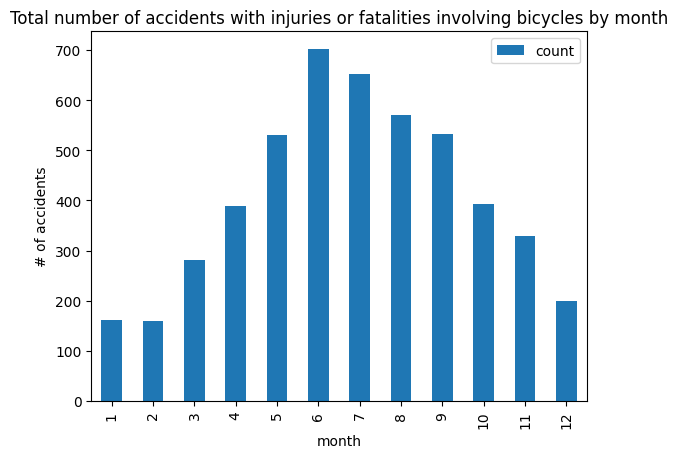

In [97]:
ax = accidents_agg.plot.bar(x='_id', y='count', 
                        title='Total number of accidents with injuries or fatalities involving bicycles by month')
ax.set_xlabel("month")
ax.set_ylabel("# of accidents")

#### Total number of accidents with injuries or fatalities involving bicycles by month

In [91]:
pipeline = [
        { "$project": {"_id": 1, "involvingBicycle": 1, "month": 1, "month_number": 1, "severityCategory": 1}},
        { "$match": {"involvingBicycle": {"$eq": "true"}}},
        { "$addFields": {"month_int": {"$toInt": "$month_number"}}}, # convert month_number to Int
        { "$addFields": {
          "deadly_acc": { "$cond": {"if": {"$eq": ["$severityCategory", "as1"]}, "then":1, "else":0}},
          "severe_inj": { "$cond": {"if": {"$eq": ["$severityCategory", "as2"]}, "then":1, "else":0}},
          "light_inj": { "$cond": {"if": {"$eq": ["$severityCategory", "as3"]}, "then":1, "else":0}}}},
        { "$group": {
                    "_id": "$month_int",
                    "deadly": { "$sum": "$deadly_acc"}, 
                    "severe": { "$sum": "$severe_inj"},
                    "light": { "$sum": "$light_inj"}}},
        { "$sort": { "_id": 1}}
        ]

cursor = client['zh_accidents'].accidents_flat.aggregate(pipeline)

accidents_agg = pd.DataFrame(cursor)
accidents_agg

,_id,deadly,severe,light
0,1,0,34,127
1,2,1,39,120
2,3,0,51,231
3,4,4,76,309
4,5,1,112,417
5,6,3,156,543
6,7,1,125,526
7,8,0,106,465
8,9,5,107,420
9,10,1,80,312


Next we plot the dataframe as line chart:

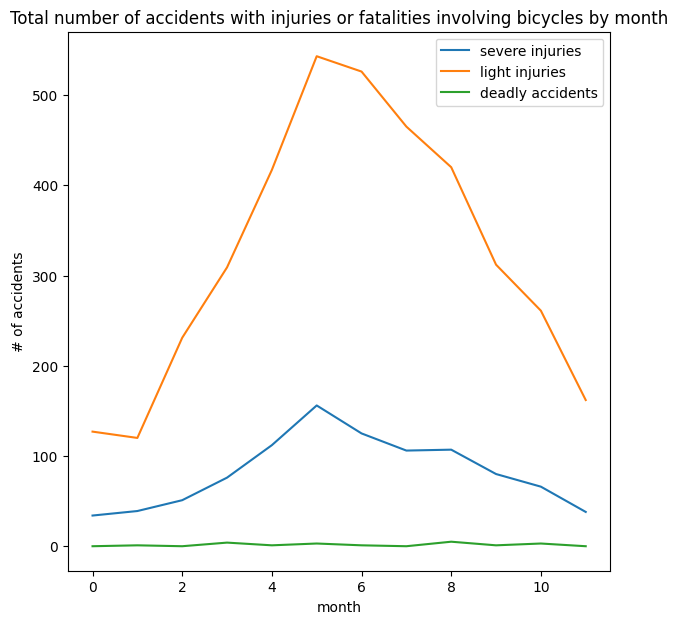

In [92]:
fig,ax = plt.subplots(figsize = (7, 7))
ax = accidents_agg['severe'].plot(
    title='Total number of accidents with injuries or fatalities involving bicycles by month')
accidents_agg['light'].plot(ax=ax)
accidents_agg['deadly'].plot(ax=ax)
ax.set_xlabel("month")
ax.set_ylabel("# of accidents")
ax.legend(["severe injuries", "light injuries", "deadly accidents"]);

As expected, the number of accidents is highest during the summer months. Due to the milder temperatures, more cyclists are on the road, which leads to more accidents. However, it can be seen that the number of fatal accidents is higher in spring and autumn.  

### Accidents by road type

This subsection examines accidents by road type. 

#### Total number of accidents with injuries or fatalities involving bicycles by road type

In [98]:
pipeline = [
        { "$project": {"_id": 1, "involvingBicycle": 1, "roadType": 1, "severityCategory": 1}},
        { "$match": {"involvingBicycle": {"$eq": "true"}, "severityCategory": {"$ne": "as4"}}},
        { "$group": { "_id": "$roadType", "count": {"$sum": 1}}},
        { "$sort": { "_id": 1}}
        ]

cursor = client['zh_accidents'].accidents_flat.aggregate(pipeline)

accidents_agg = pd.DataFrame(cursor)
accidents_agg

,_id,count
0,Minor road,3524
1,Other,151
2,Principal road,1227


Next we plot the dataframe as bar plot:

Text(0, 0.5, '# of accidents')

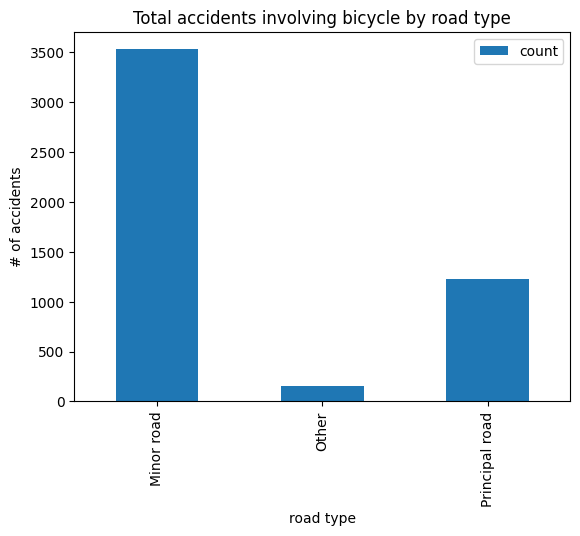

In [99]:
ax = accidents_agg.plot.bar(x='_id', y='count', title='Total accidents involving bicycle by road type')
ax.set_xlabel("road type")
ax.set_ylabel("# of accidents")

#### Total number of accidents with  fatalities involving bicycles by road type 

In [355]:
pipeline = [
        { "$project": {"_id": 1, "involvingBicycle": 1, "roadType": 1, "severityCategory": 1}},
        { "$match": {"involvingBicycle": {"$eq": "true"}, "severityCategory": {"$eq": "as1"}}},
        { "$group": { "_id": "$roadType", "count": {"$sum": 1}}},
        { "$sort": { "_id": 1} }
        ]

cursor = client['zh_accidents'].accidents_flat.aggregate(pipeline)

accidents_agg = pd.DataFrame(cursor)
accidents_agg

,_id,count
0,Minor road,13
1,Principal road,6


Next we plot the dataframe as bar plot:

Text(0, 0.5, '# of accidents')

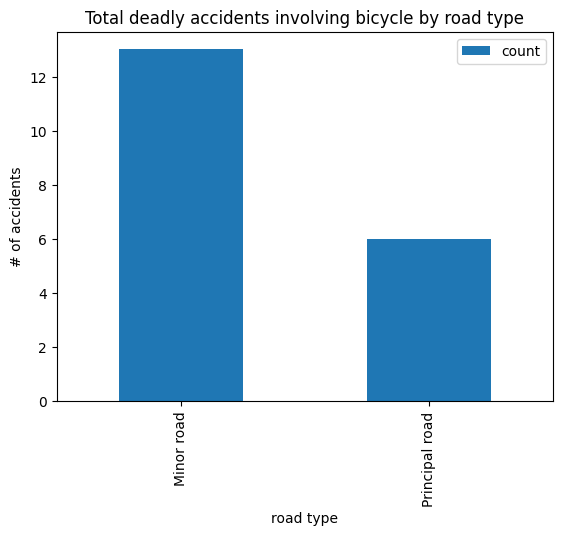

In [102]:
ax = accidents_agg.plot.bar(x='_id', y='count', title='Total deadly accidents involving bicycle by road type')
ax.set_xlabel("road type")
ax.set_ylabel("# of accidents")

Accidents happen most frequently on secondary roads. Accidents on main roads are less than half as frequent. The same applies to the fatal accidents.

### Accidents with bicycle by accident type

In this subchapter the accidents are distinguished by accident type. The data distinguish between the following accident types:
- Accident involving animal(s)
- Accident involving pedestrian(s)
- Accident when crossing the lane(s)
- Accident when overtaking or changing lanes
- Accident when parking
- Accident when turning left or right
- Accident when turning-into main road
- Accident with head-on collision
- Accident with rear-end collision
- Accident with skidding or self-accident

#### Total number of accidents with injuries or fatalities involving bicycles by accident type

In [103]:
pipeline = [
        { "$project": {"_id": 1, "involvingBicycle": 1, "accidentType": 1, "severityCategory": 1}},
        { "$match": {"involvingBicycle": {"$eq": "true"}}},
        { "$group": { "_id": "$accidentType", "count": {"$sum": 1}}}
        ]

cursor = client['zh_accidents'].accidents_flat.aggregate(pipeline)

accidents_agg = pd.DataFrame(cursor)
accidents_agg

,_id,count
0,Accident with rear-end collision,373
1,Accident involving pedestrian(s),337
2,Other,15
3,Accident with skidding or self-accident,2203
4,Accident when turning left or right,835
5,Accident when turning-into main road,547
6,Accident involving animal(s),19
7,Accident with head-on collision,160
8,Accident when parking,246
9,Accident when overtaking or changing lanes,586


Next we plot the dataframe as bar plot:

Text(0, 0.5, '# of accidents')

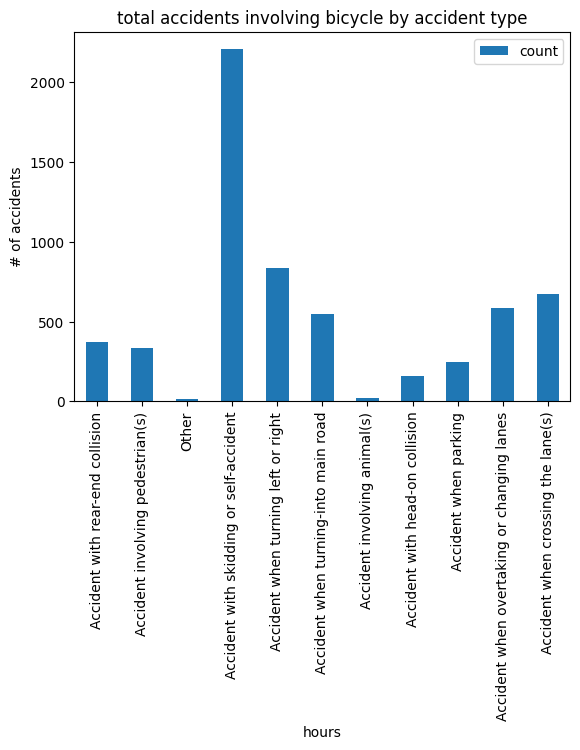

In [104]:
ax = accidents_agg.plot.bar(x='_id', y='count', title='total accidents involving bicycle by accident type')
ax.set_xlabel("hours")
ax.set_ylabel("# of accidents")

By far the most accidents are caused by slipping or are self-inflicted. The second most frequent accidents occur when turning and the third most frequent when changing lanes. <br>
Now let's examine only the types of accidents in fatal bicycle accidents.

#### Total number of accidents with fatalities involving bicycles by accident type

In [105]:
# count and sort deadly of accident involving bicycle by accident type
pipeline = [
        { "$project": {"_id": 1, "involvingBicycle": 1, "accidentType": 1, "severityCategory": 1}},
        { "$match": {"involvingBicycle": {"$eq": "true"}, "severityCategory": { "$eq": "as1"}}},
        { "$group": { "_id": "$accidentType", "count": {"$sum": 1}}}
        ]

cursor = client['zh_accidents'].accidents_flat.aggregate(pipeline)
accidents_agg = pd.DataFrame(cursor)
accidents_agg

,_id,count
0,Accident when turning left or right,5
1,Accident with skidding or self-accident,7
2,Accident when crossing the lane(s),4
3,Accident when overtaking or changing lanes,1
4,Accident involving pedestrian(s),2


Next we plot the dataframe as bar plot:

Text(0, 0.5, '# of accidents')

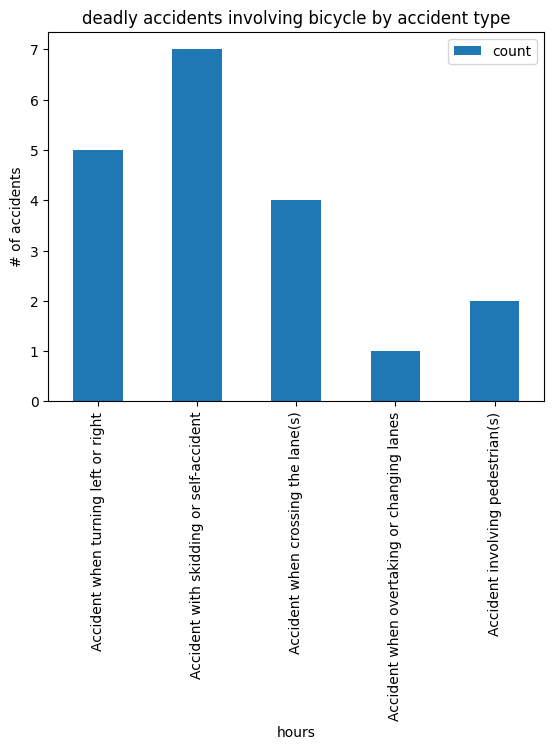

In [106]:
ax = accidents_agg.plot.bar(x='_id', y='count', title='deadly accidents involving bicycle by accident type')
ax.set_xlabel("hours")
ax.set_ylabel("# of accidents")

The most common types of accidents in fatal bicycle accidents are the same as in other accidents.

### Location of accidents

In this subchapter, the accident location is to be examined. It is to be shown whether certain intersections or road sections are particularly dangerous for cyclists. For this purpose, the coordinates of the respective accident locations are not projected onto a map and thus a graphical representation of the accident locations is obtained.

#### Create dataframe with coordinates of all accidents with injuries or fatalities involving bycicles

In [356]:
pipeline = [
        {"$project": {"_id": 1, "loc_geo_coord_long": 1, "loc_geo_coord_latt": 1, 
                         "involvingBicycle": 1, "year": 1, "severityCategory": 1}},
        {"$match": {"involvingBicycle": {"$eq": "true"}}}
        ]

cursor = client['zh_accidents'].accidents_flat.aggregate(pipeline)

accidents_loc = pd.DataFrame(cursor)
accidents_loc

,_id,involvingBicycle,severityCategory,year,loc_geo_coord_long,loc_geo_coord_latt
0,63a30a09f023c0daa78a5e6e,true,as3,2011,8.53,47.37
1,63a30a09f023c0daa78a5e76,true,as2,2011,8.54,47.37
2,63a30a09f023c0daa78a5e80,true,as3,2011,8.51,47.37
3,63a30a09f023c0daa78a5e85,true,as3,2011,8.55,47.36
4,63a30a09f023c0daa78a5ec2,true,as3,2011,8.55,47.41
...,...,...,...,...,...,...
5986,63a30a09f023c0daa78b2f0c,true,as2,2021,8.55,47.38
5987,63a30a09f023c0daa78b2f12,true,as3,2021,8.55,47.37
5988,63a30a09f023c0daa78b2f14,true,as4,2021,8.52,47.39
5989,63a30a09f023c0daa78b2f27,true,as3,2021,8.54,47.38


#### Load map and set coordinate system

In [77]:
# load map
street_map = gpd.read_file("data/geoz.sv_str_lin.shp")
# change CRS to epsg 4326
street_map = street_map.to_crs(epsg=4326)
# write shp file
street_map.to_file("data/geoz.sv_str_lin.shp")
# define coordinate system 
crs = {'init': 'epsg:4326'}

#### Create geospatial dataframe

In [109]:
# create geospatial points from df
geometry = [Point(xy) for xy in zip( accidents_loc["loc_geo_coord_long"], accidents_loc["loc_geo_coord_latt"])]
geometry[:3]

[<POINT (8.529 47.369)>, <POINT (8.541 47.367)>, <POINT (8.514 47.374)>]

In [ ]:
# create geospatial df
geo_df = gpd.GeoDataFrame(accidents_loc, crs = crs, geometry = geometry)
geo_df.head()

#### Plot locations of deadly accidents involving bicycles

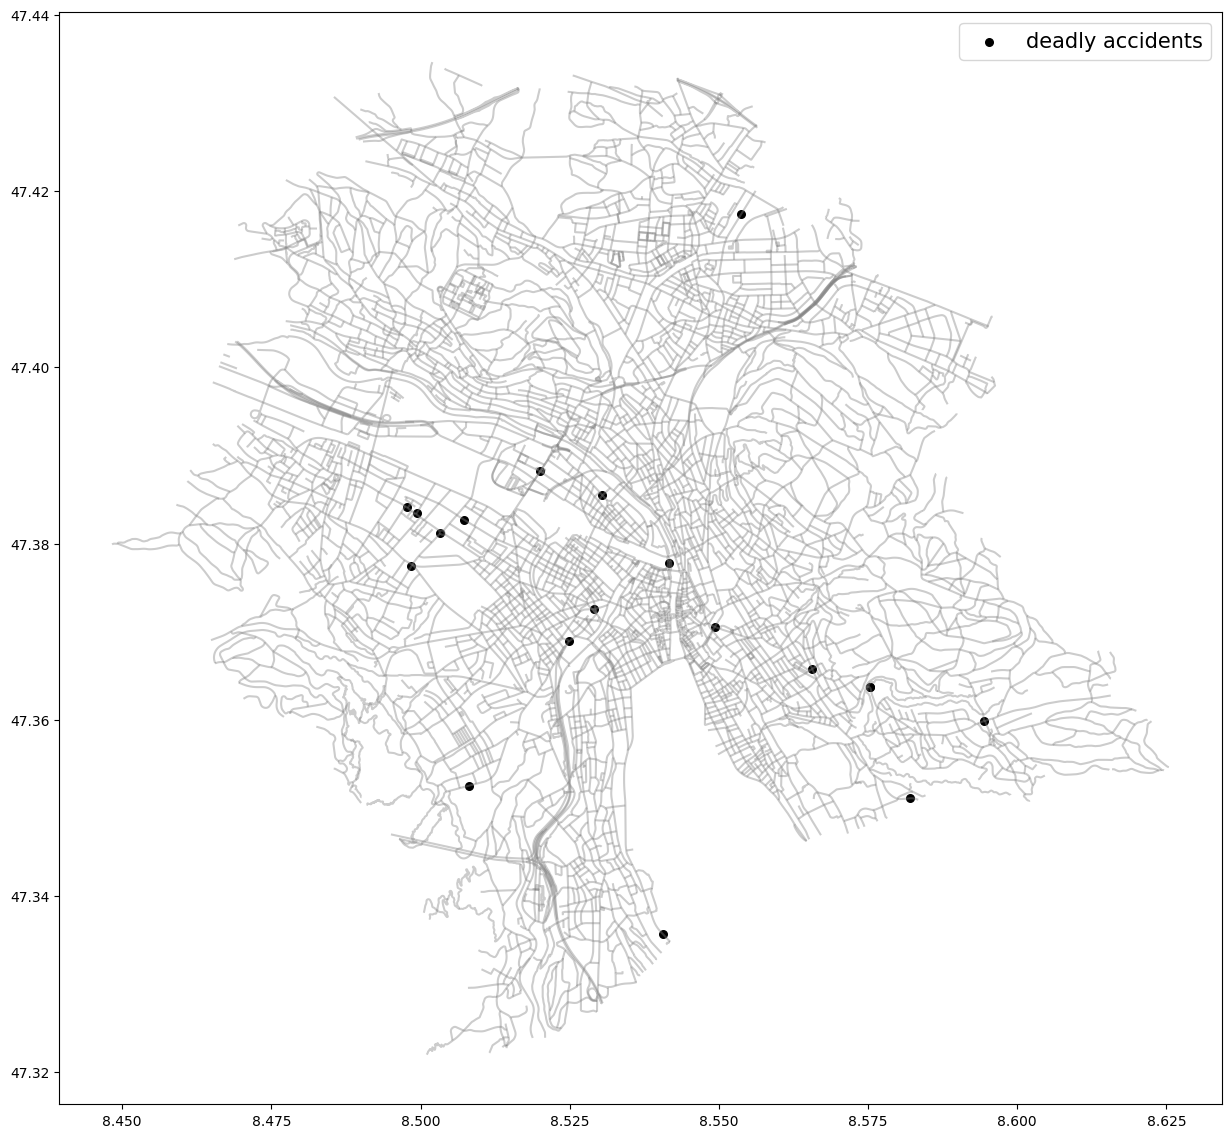

In [80]:
# plot points on map
fig,ax = plt.subplots(figsize = (15, 15))
street_map.plot(ax = ax, alpha=0.4, color="grey")
geo_df[geo_df['severityCategory'] == 'as1'].plot(
    ax = ax, markersize = 30, color = 'black', marker = 'o', label = 'deadly accidents')
plt.legend(prop={'size': 15})

#### Plot loacations of accidnets with severe injuries

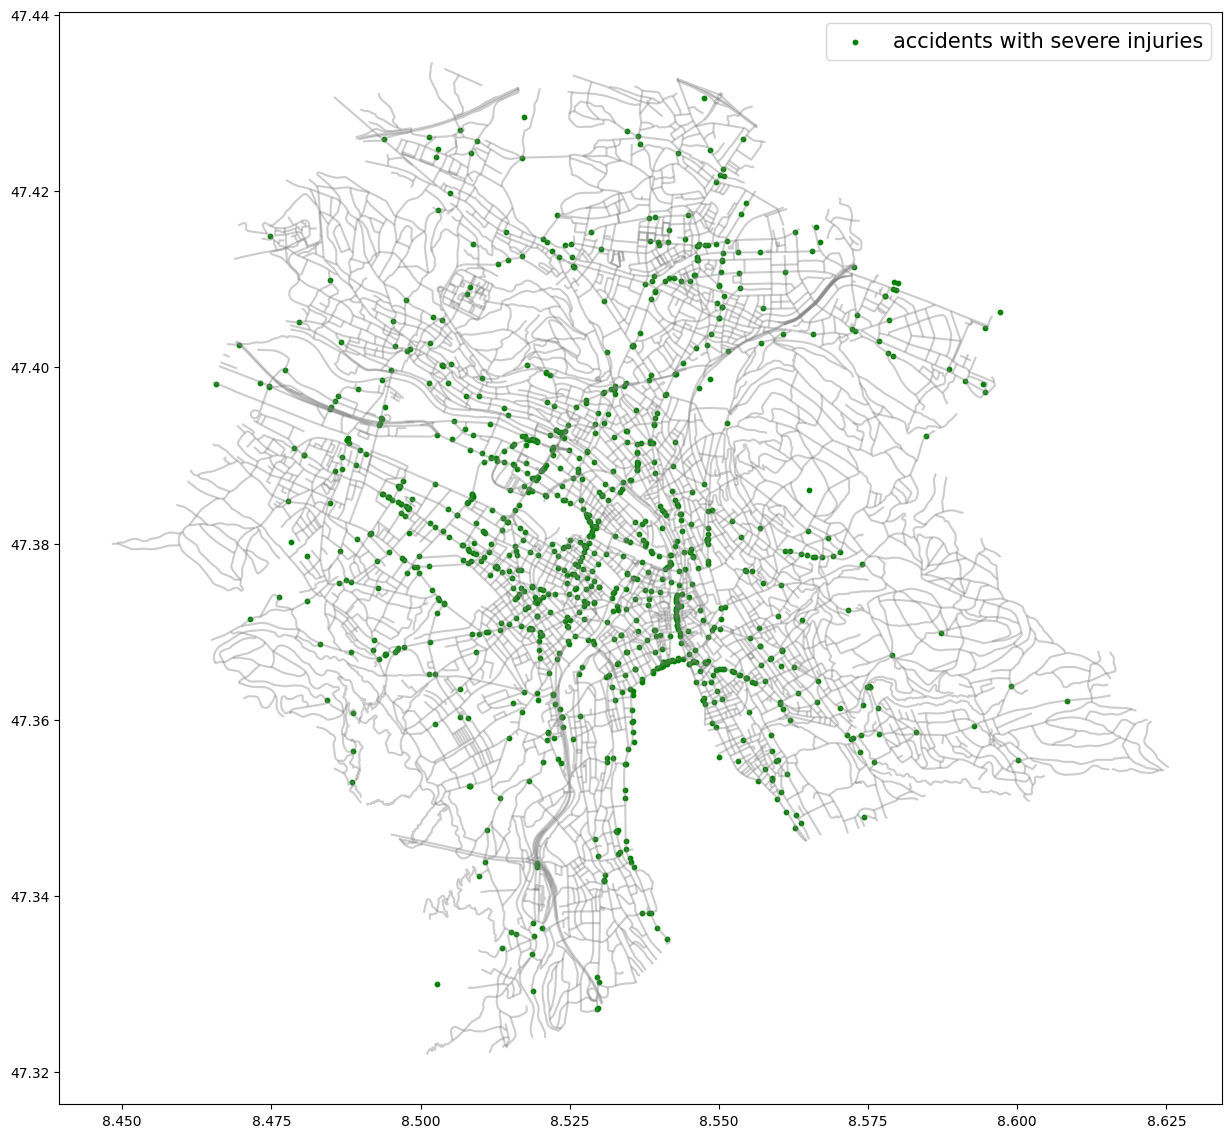

In [81]:
# plot points on map
fig,ax = plt.subplots(figsize = (15, 15))
street_map.plot(ax = ax, alpha=0.4, color="grey")
geo_df[geo_df['severityCategory'] == 'as2'].plot(
    ax = ax, markersize = 10, color = 'green', marker = 'o', label = 'accidents with severe injuries')
plt.legend(prop={'size': 15})

#### Plot locations of accidents with light injuries

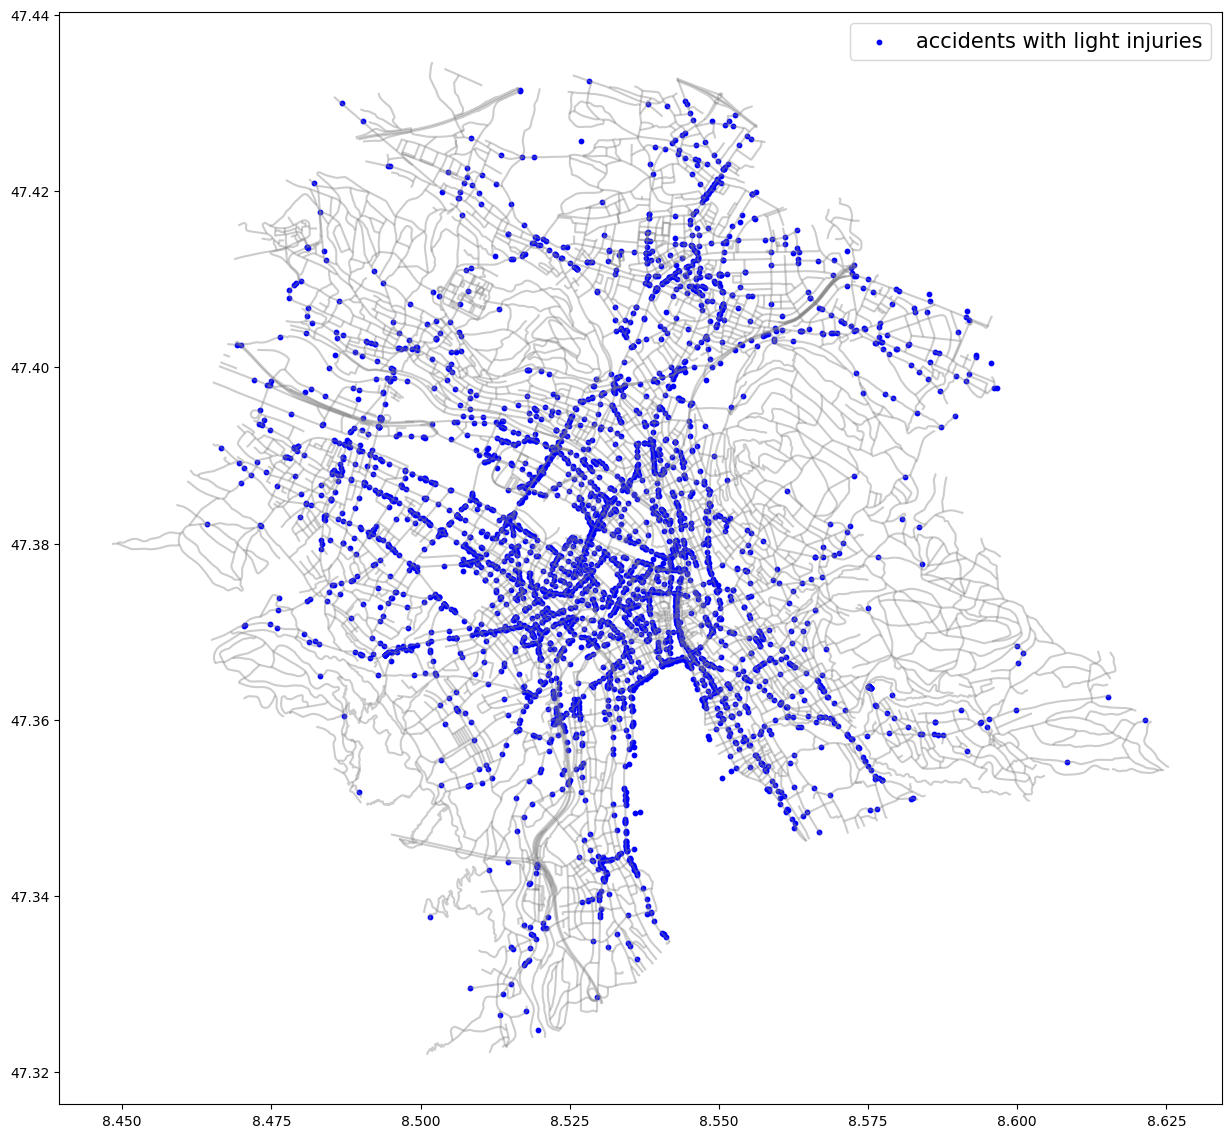

In [82]:
# plot points on map
fig,ax = plt.subplots(figsize = (15, 15))
street_map.plot(ax = ax, alpha=0.4, color="grey")
geo_df[geo_df['severityCategory'] == 'as3'].plot(
    ax = ax, markersize = 10, color = 'blue', marker = 'o', label = 'accidents with light injuries')
plt.legend(prop={'size': 15})

The graphs above show the locations of bicycle accidents in the city of Zurich. For a better overview, the accidents were shown individually according to accident severity. <br>
Accidents with severe injuries and accidnets with light injuries are are equally distribute while deadly accidents tend to happen on major crossroads.

## Conclusions

This analysis revealed that accidents resulting in minor and serious injuries occur in a seasonal pattern, with the highest occurrences during the summer and fall months. Furthermore, the data showed that these accidents tend to happen at specific times of the day, with peak occurrences during the evening hours. Most of these accidents were found to be caused by the individuals themselves. The data also showed that accidents with injuries are more prevalent in the city center, likely due to the higher volume of traffic and concentration of bike lanes in this area. However, there is no discernible pattern in fatal bicycle accidents, with most fatal accidents happening towards the end of the year. This could be due to a variety of factors such as weather conditions or lack of daylight during the end of the year. 

## Remarks

### Learnings

This analysis demonstrated the use of various operators in MongoDB to create nested queries and adjust them quickly using pipeline generation. The operators that were used in this analysis include the $match, $project, $group, $sort and $limit operators. The ability to flatten JSON structures and convert data types in the pipeline proved to be useful in cleaning and transforming the data. The process of testing and refining the different stages resulted in finding the best way to achieve the desired output. However, implementing a 2dsphere query, which is used to query geospatial data, was not successful due to unresolved error messages. This was a limitation of the analysis, but to compensate for this, the geo-data was generated using additional Python libraries such as Folium, after retrieving the necessary data through MongoDB aggregation. The resulting visualization provided a clear and useful representation of the data and helped in understanding the patterns and trends in the data set.

In [354]:
%%HTML
<style>
/* display:none  -> hide In/Out column */
/* display:block -> show In/Out column */
div.prompt {display:none}

/* removes inserted URL after links when printing */
@media print {
    a[href]:after { content: none; }         
}
</style>